In [1]:
import os
from pathlib import Path
import pandas as pd
import re
from collections import Counter

# Define path
DATA_PATH = Path("../data/new_ocr")

# Check if path exists
if not DATA_PATH.exists():
    print(f"Warning: {DATA_PATH} does not exist. Please check your data directory.")
else:
    print(f"Data path: {DATA_PATH}")

Data path: ..\data\new_ocr


In [2]:
# Load all markdown files into a dictionary
# Structure: { "filename": { "content": "...", "year": "...", "original_data_path": "..." } }

data_store = {}

files = list(DATA_PATH.rglob("*.md"))

for file_path in files:
    try:
        # Extract year from parent folder name (e.g., ntt_2024 -> 2024)
        parent_name = file_path.parent.name
        
        if parent_name.startswith("ntt_"):
            year = parent_name.split("ntt_")[-1]
        elif parent_name.isdigit():
            year = parent_name
        else:
            # Fallback: Try to find year in the filename itself (e.g. sr2024)
            match = re.search(r'20\d{2}', file_path.stem)
            year = match.group(0) if match else "Unknown"
        
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()
            
        # Construct original data path (assuming parallel structure in data/raw)
        # We replace 'ocr_results' with 'raw' and extension '.md' with '.pdf'
        # Also need to handle the 'ntt_' prefix in the folder name if raw doesn't have it
        # Raw structure seen earlier: data/raw/2024/sr2024.pdf
        # OCR structure: data/ocr_results/ntt_2024/sr2024.md
        
        relative_path = file_path.relative_to(DATA_PATH)
        # relative_path is like ntt_2024/sr2024.md
        
        # Construct raw path: data/raw/2024/sr2024.pdf
        # We use the extracted year for the folder
        raw_path = Path("../data/raw") / year / file_path.with_suffix(".pdf").name
        original_data_path = str(raw_path)
            
        data_store[file_path.name] = {
            "content": content,
            "year": year,
            "path": str(file_path),
            "original_data_path": original_data_path
        }
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

print(f"Loaded {len(data_store)} files.")
for name, info in data_store.items():
    print(f"- {name} (Year: {info['year']}, Original: {info['original_data_path']})")

Loaded 10 files.
- sr_2019_p.md (Year: 2019, Original: ..\data\raw\2019\sr_2019_p.pdf)
- sr_2020.md (Year: 2020, Original: ..\data\raw\2020\sr_2020.pdf)
- sr_2020_cb_p.md (Year: 2020, Original: ..\data\raw\2020\sr_2020_cb_p.pdf)
- sr_2021.md (Year: 2021, Original: ..\data\raw\2021\sr_2021.pdf)
- sr_2020_cb_v.md (Year: 2022, Original: ..\data\raw\2022\sr_2020_cb_v.pdf)
- sr_2022.md (Year: 2022, Original: ..\data\raw\2022\sr_2022.pdf)
- sr2023.md (Year: 2023, Original: ..\data\raw\2023\sr2023.pdf)
- sr_2023_cb_v.md (Year: 2023, Original: ..\data\raw\2023\sr_2023_cb_v.pdf)
- sr2024.md (Year: 2024, Original: ..\data\raw\2024\sr2024.pdf)
- sr_2024_cb_v.md (Year: 2024, Original: ..\data\raw\2024\sr_2024_cb_v.pdf)


## Data Cleaning Function

Defines a preliminary cleaning function to remove OCR artifacts, specifically `<!-- image -->` tags. Further analysis identifies additional noise such as page numbers or headers for subsequent removal.

In [3]:
def clean_text_with_stats(text):
    stats = {
        "original_length": len(text),
        "image_tags_removed": 0
    }
    
    # 1. Remove image tags
    stats["image_tags_removed"] = text.count("<!-- image -->")
    cleaned_text = text.replace("<!-- image -->", "")
    
    stats["cleaned_length"] = len(cleaned_text)
    stats["reduction_ratio"] = 1 - (stats["cleaned_length"] / stats["original_length"]) if stats["original_length"] > 0 else 0
    
    return cleaned_text, stats

## Application of Cleaning and Result Analysis

Applies the cleaning function to each file within the `data_store` and aggregates processing statistics.

In [4]:
print(f"{'Filename':<35} | {'Year':<6} | {'Org Len':<10} | {'New Len':<10} | {'Tags Rm':<8} | {'Ratio':<8}")
print("-" * 90)

for filename, data in data_store.items():
    original_content = data["content"]
    cleaned_content, stats = clean_text_with_stats(original_content)
    
    # Store cleaned content back
    data["cleaned_content"] = cleaned_content
    data["stats"] = stats
    
    ratio = stats["reduction_ratio"] * 100
    
    print(f"{filename[:35]:<35} | {data['year']:<6} | {stats['original_length']:<10} | {stats['cleaned_length']:<10} | {stats['image_tags_removed']:<8} | {ratio:.2f}%")

Filename                            | Year   | Org Len    | New Len    | Tags Rm  | Ratio   
------------------------------------------------------------------------------------------
sr_2019_p.md                        | 2019   | 557367     | 549499     | 562      | 1.41%
sr_2020.md                          | 2020   | 663831     | 662809     | 73       | 0.15%
sr_2020_cb_p.md                     | 2020   | 42787      | 41849      | 67       | 2.19%
sr_2021.md                          | 2021   | 669885     | 668611     | 91       | 0.19%
sr_2020_cb_v.md                     | 2022   | 183994     | 182594     | 100      | 0.76%
sr_2022.md                          | 2022   | 537311     | 535435     | 134      | 0.35%
sr2023.md                           | 2023   | 867296     | 864426     | 205      | 0.33%
sr_2023_cb_v.md                     | 2023   | 81129      | 76089      | 360      | 6.21%
sr2024.md                           | 2024   | 757539     | 752569     | 355      | 0.66%
sr_202

## Cleaning Summary and Word Length Analysis

Summarizes the initial loading and basic cleaning process, highlighting the removal of OCR image tags. Subsequently, analyzes word length distributions to detect potential noise (single characters) and anomalies (concatenated words due to missing spaces), providing a foundation for further text refinement.

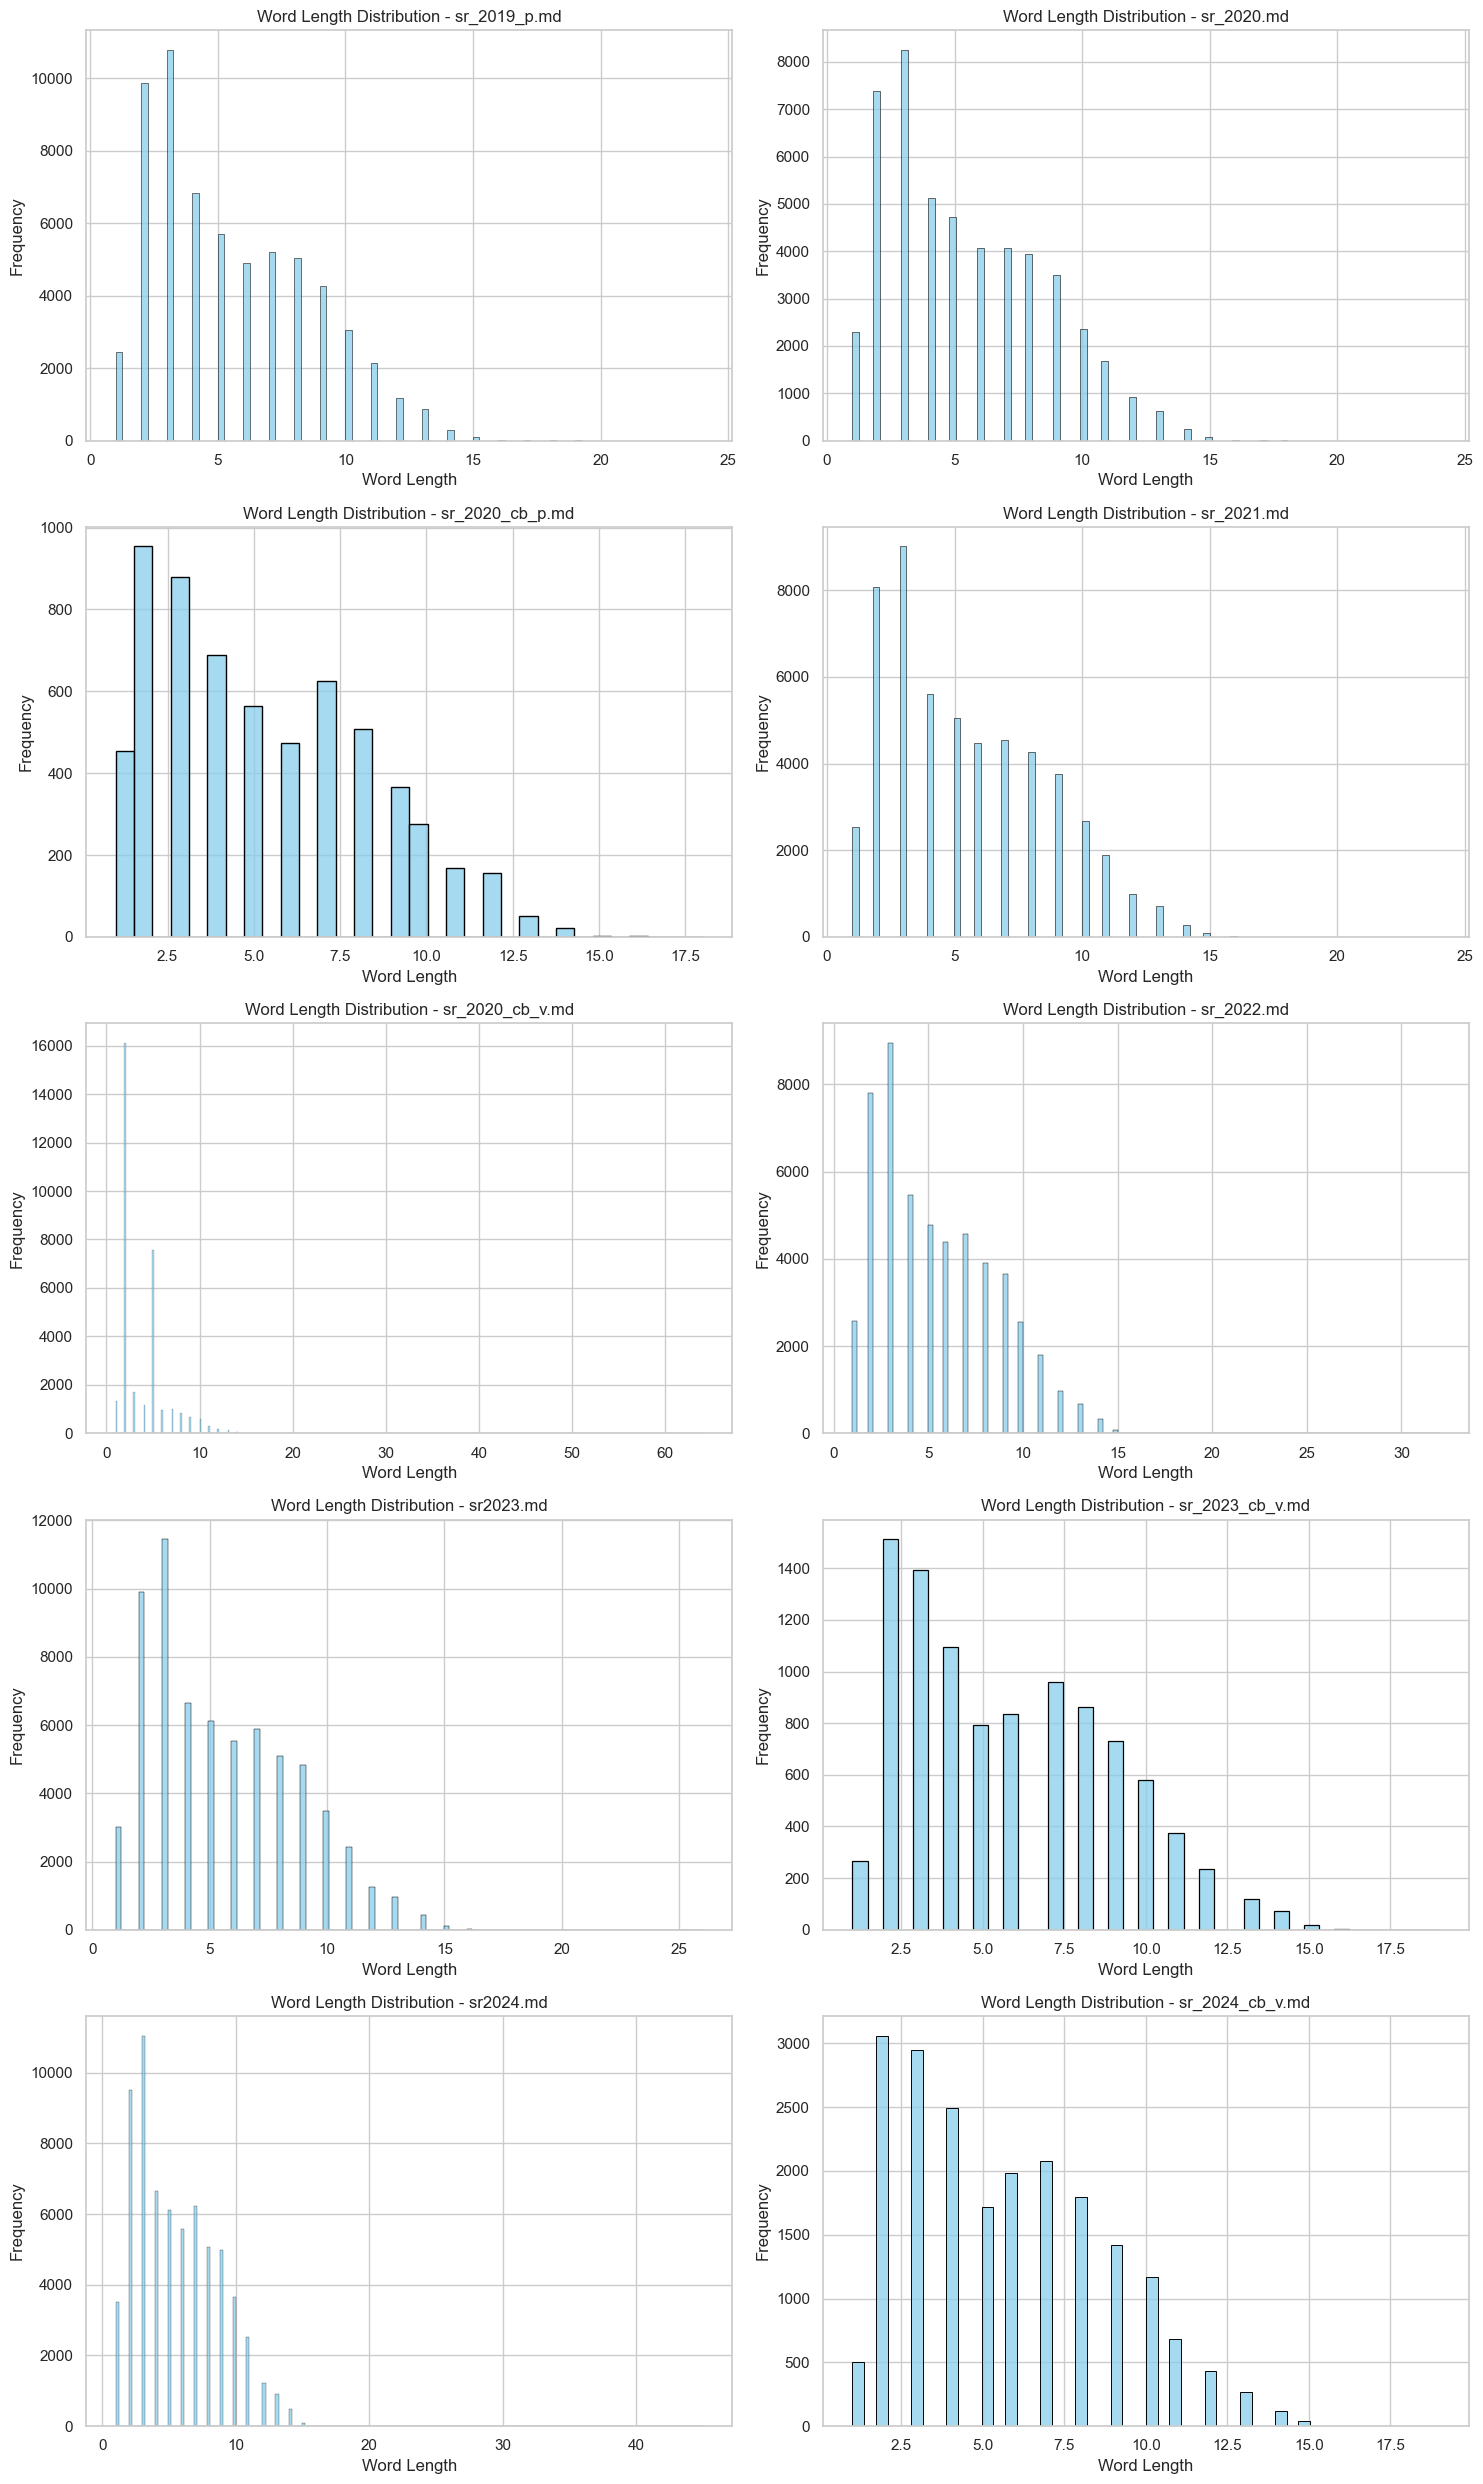


==================== Stats for: sr_2019_p.md (2019) ====================
1-Character Words (Total: 2432):
Top 10: [('a', 712), ('0', 326), ('1', 252), ('s', 235), ('2', 155), ('3', 122), ('5', 89), ('4', 82), ('6', 52), ('t', 48)]
Longest Words (Top 10):
['hydrochlorofluorocarbons', 'chlorofluorocarbons', 'informationoriented', 'environmentfriendly', 'telecommunications', 'hydrofluorocarbons', 'vizualizareArticol', 'Telecommunications', 'telecommunication', 'commercialization']

==================== Stats for: sr_2020.md (2020) ====================
1-Character Words (Total: 2291):
Top 10: [('a', 482), ('0', 332), ('1', 265), ('2', 219), ('s', 206), ('3', 130), ('5', 113), ('4', 95), ('e', 56), ('t', 46)]
Longest Words (Top 10):
['hydrochlorofluorocarbons', 'multinationalization', 'telecommunications', 'hydrofluorocarbons', 'Telecommunications', 'commercialization', 'Hydrofluorocarbon', 'videoconferencing', 'essuronceengogen', 'teleconferencing']

==================== Stats for: sr_202

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_word_lengths(text):
    # Split by whitespace to get words, remove punctuation for cleaner length check
    words = re.findall(r'\b\w+\b', text)
    lengths = [len(w) for w in words]
    return words, lengths

# Set style
sns.set_theme(style="whitegrid")

# Process all files first to gather data
all_lengths = {}
for filename, data in data_store.items():
    words, lengths = analyze_word_lengths(data["cleaned_content"])
    if words:
        all_lengths[filename] = lengths

# Create subplots
num_files = len(all_lengths)
cols = 2
rows = (num_files + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, (filename, lengths) in enumerate(all_lengths.items()):
    ax = axes[i]
    # Use simple histplot without kde and without fixed bin range
    sns.histplot(lengths, kde=False, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f"Word Length Distribution - {filename}")
    ax.set_xlabel("Word Length")
    ax.set_ylabel("Frequency")
    # Let seaborn/matplotlib decide the ticks based on data range

# Hide empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print stats separately to keep charts clean
for filename, data in data_store.items():
    words, lengths = analyze_word_lengths(data["cleaned_content"])
    if not words: continue
    
    print(f"\n{'='*20} Stats for: {filename} ({data['year']}) {'='*20}")
    
    # 1. Shortest Words (Length 1)
    short_words = [w for w in words if len(w) == 1]
    short_counts = Counter(short_words)
    print(f"1-Character Words (Total: {len(short_words)}):")
    print(f"Top 10: {short_counts.most_common(10)}")
    
    # 2. Longest Words (Top 10 by length)
    unique_words = list(set(words))
    unique_words.sort(key=len, reverse=True)
    print(f"Longest Words (Top 10):")
    print(unique_words[:10])

## Handling Concatenated Words

Addresses the issue of concatenated words resulting from missing spaces. Implements a heuristic to identify and list unusually long alphabetic tokens (greater than 20 characters) to assess the extent of this OCR artifact.

In [6]:
# Detect and REMOVE suspicious long words
removed_tokens = []

for filename, data in data_store.items():
    content = data["cleaned_content"]
    words, _ = analyze_word_lengths(content)
    
    # Filter for words longer than 20 chars and purely alphabetic
    # w.isalpha() checks if all characters in the string are letters (no numbers or symbols)
    long_tokens = set() # Use set to avoid processing the same word twice in one file
    for w in words:
        is_long = len(w) > 20
        is_only_letters = w.isalpha()
        
        if is_long and is_only_letters:
            long_tokens.add(w)
    
    if long_tokens:
        # Remove these tokens from the content
        for token in long_tokens:
            # Use regex to replace only whole words
            pattern = r'\b' + re.escape(token) + r'\b'
            content = re.sub(pattern, '', content)
            
            removed_tokens.append((filename, token))
        
        # Update the store with the cleaner content
        data["cleaned_content"] = content

# Sort by length to show the longest ones first
removed_tokens.sort(key=lambda x: len(x[1]), reverse=True)

print(f"Removed {len(removed_tokens)} suspicious long tokens.")
print("Top 20 Longest Removed Words:")
for filename, word in removed_tokens[:20]:
    print(f"[{filename}] {word} (Len: {len(word)})")

Removed 24 suspicious long tokens.
Top 20 Longest Removed Words:
[sr_2020_cb_v.md] tatoWekWAuvDeAuHRWisuWtfeofWblWaefWltAcuAkRWtkWhurrWtkWisuWAuHD (Len: 63)
[sr_2020_cb_v.md] RWtWaefWltAceofWkDaabAiWkSkiucRWtkWatAiWblWisuWyCctAiWƒefW (Len: 58)
[sr_2020_cb_v.md] GaGInaPrnGpinifinvGprnGDvPDumrnGriaCupraGmrluPAaeurEuGu (Len: 55)
[sr_2020_cb_v.md] OversaGorouaepcramsnGnpieainDurvetaGnbainvGpraGmr (Len: 49)
[sr_2020_cb_v.md] pfdueumrAevsrixuruGvesvfpraGmrIvsgPnIaiumrlveB (Len: 46)
[sr2024.md] Newwaysofworkingthatenhanceemployeeexperience (Len: 45)
[sr_2020_cb_v.md] eofWkDkiteotgruWaefWltAceofWisAbDfsW (Len: 36)
[sr_2020_cb_v.md] bcuWekkDukNWmoWAukabokuWibWisukuW (Len: 33)
[sr_2020_cb_v.md] sgevDnGtruAAnInuGIorvArpvInuiorr (Len: 32)
[sr_2020_cb_v.md] nkWisuWkitgruWkDaarSWblWabAXWeoW (Len: 32)
[sr_2020_cb_v.md] pglpGAalIrlcromzpydsfdpdropdsbdp (Len: 32)
[sr_2020_cb_v.md] toHWisuWiAtokluAWblWgAuuHeofWiu (Len: 31)
[sr_2020_cb_v.md] yaalpslounrlfapfgvArlsaoprl (Len: 27)
[sr_2020_cb_v.md] ixevftx

## Removal of Single Character Lines

Targets vertical text artifacts where text is split into single characters on separate lines. Removes lines containing only a single letter while preserving single digits (page numbers) and punctuation for context.

In [7]:
# Clean single character lines (Letters only)
cleaned_total = 0
for filename, data in data_store.items():
    lines = data["cleaned_content"].split('\n')
    new_lines = []
    file_removed_count = 0
    
    for line in lines:
        stripped = line.strip()
        
        # Remove if it is a single letter
        if len(stripped) == 1 and stripped.isalpha():
            file_removed_count += 1
            continue
            
        new_lines.append(line)
    
    data["cleaned_content"] = "\n".join(new_lines)
    cleaned_total += file_removed_count
    
    if file_removed_count > 0:
        print(f"[{filename}] Removed {file_removed_count} single-letter lines.")

print(f"\nTotal single-letter lines removed: {cleaned_total}")

# Verify
print("\nVerification:")
remaining_singles = 0
for filename, data in data_store.items():
    lines = data["cleaned_content"].split('\n')
    singles = [l.strip() for l in lines if len(l.strip()) == 1 and l.strip().isalpha()]
    remaining_singles += len(singles)
    if singles:
        print(f"Warning: {filename} still has {len(singles)} single letters.")

if remaining_singles == 0:
    print("All single-letter lines successfully removed.")

[sr_2020_cb_p.md] Removed 2 single-letter lines.
[sr_2020_cb_v.md] Removed 551 single-letter lines.
[sr_2022.md] Removed 14 single-letter lines.
[sr2023.md] Removed 2 single-letter lines.

Total single-letter lines removed: 569

Verification:
All single-letter lines successfully removed.


In [8]:
# Check for "GLYPH" artifacts
glyph_counts = {}
for filename, data in data_store.items():
    count = data["cleaned_content"].count("GLYPH")
    if count > 0:
        glyph_counts[filename] = count

print(f"Files containing 'GLYPH' artifacts: {len(glyph_counts)}")
for filename, count in glyph_counts.items():
    print(f"{filename}: {count} occurrences")

# Show a sample context
if glyph_counts:
    first_file = list(glyph_counts.keys())[0]
    content = data_store[first_file]["cleaned_content"]
    match = re.search(r'(.{20}GLYPH<\d+>.{20})', content)
    if match:
        print(f"\nSample context in {first_file}:")
        print(f"...{match.group(1)}...")

Files containing 'GLYPH' artifacts: 1
sr_2020_cb_v.md: 6541 occurrences

Sample context in sr_2020_cb_v.md:
...GLYPH<16> GLYPH<13> GLYPH<15> GLYPH<13> GLYPH<20>...


## Removal of Encoding Artifacts (GLYPH)

Identifies and removes `GLYPH<...>` patterns, which represent font encoding errors from the PDF extraction process. Uses regular expressions to eliminate these unreadable artifacts.

In [9]:
# Remove GLYPH artifacts
# Matches GLYPH<123> or GLYPH&lt;123&gt; (HTML encoded)
glyph_pattern = re.compile(r'GLYPH(?:<|&lt;)\d+(?:>|&gt;)')

total_glyphs_removed = 0

for filename, data in data_store.items():
    content = data["cleaned_content"]
    
    # Count before removing
    count = len(glyph_pattern.findall(content))
    
    if count > 0:
        # Remove the pattern
        new_content = glyph_pattern.sub('', content)
        data["cleaned_content"] = new_content
        total_glyphs_removed += count
        print(f"[{filename}] Removed {count} GLYPH artifacts.")

print(f"\nTotal GLYPH artifacts removed: {total_glyphs_removed}")

# Verification: Check if any "GLYPH" text remains (catch-all)
remaining = 0
for filename, data in data_store.items():
    if "GLYPH" in data["cleaned_content"]:
        print(f"WARNING: {filename} still contains 'GLYPH'")
        # Print a snippet to see what pattern we missed
        idx = data["cleaned_content"].find("GLYPH")
        print(f"Context: ...{data['cleaned_content'][idx:idx+50]}...")
        remaining += 1

if remaining == 0:
    print("No 'GLYPH' strings found in any file.")

[sr_2020_cb_v.md] Removed 6541 GLYPH artifacts.

Total GLYPH artifacts removed: 6541
No 'GLYPH' strings found in any file.


## Removal of Noise Symbols

Eliminates specific noise characters and encoding artifacts (e.g., Windows-1252 remnants) that appear as isolated garbage or clusters within the text.

In [10]:
# Remove specific noise symbols identified
# These include: · ­ € ƒ … † ‡ ˆ ‰ Š ‹ Œ Ž ˜ and similar Windows-1252 artifacts
noise_chars = "·­€ƒ…†‡ˆ‰Š‹ŒŽ˜™š›œžŸ‚„"
noise_pattern = re.compile(f"[{re.escape(noise_chars)}]")

total_noise_removed = 0

for filename, data in data_store.items():
    content = data["cleaned_content"]
    
    matches = noise_pattern.findall(content)
    count = len(matches)
    
    if count > 0:
        # Remove them (replace with empty string)
        new_content = noise_pattern.sub('', content)
        data["cleaned_content"] = new_content
        total_noise_removed += count
        print(f"[{filename}] Removed {count} noise symbols.")

print(f"\nTotal noise symbols removed: {total_noise_removed}")

[sr_2019_p.md] Removed 3 noise symbols.
[sr_2020.md] Removed 4 noise symbols.
[sr_2020_cb_p.md] Removed 3 noise symbols.
[sr_2021.md] Removed 5 noise symbols.
[sr_2020_cb_v.md] Removed 129 noise symbols.
[sr_2022.md] Removed 5 noise symbols.
[sr2023.md] Removed 6 noise symbols.
[sr2024.md] Removed 7 noise symbols.
[sr_2024_cb_v.md] Removed 4 noise symbols.

Total noise symbols removed: 166


## Removal of Punctuation Noise Lines

Removes lines that contain no alphanumeric characters (letters or digits) but consist of punctuation or symbols. This targets OCR artifacts like isolated commas, quotes, or dashes, while preserving table separators.

In [11]:
# Remove lines that consist mainly of punctuation (no alphanumeric chars)
# But preserve table separators (lines with |, -, +, :)

punctuation_noise_removed = 0

for filename, data in data_store.items():
    lines = data["cleaned_content"].split('\n')
    new_lines = []
    file_removed_count = 0
    
    for line in lines:
        stripped = line.strip()
        
        # Skip empty lines (handled by whitespace normalization later)
        if not stripped:
            new_lines.append(line)
            continue
            
        # Check if line has any alphanumeric character
        has_alnum = any(c.isalnum() for c in stripped)
        
        if not has_alnum:
            # It contains only symbols/punctuation/whitespace
            # Check if it is a table separator or border
            # Table lines usually contain '|'
            is_table_part = '|' in stripped or re.match(r'^[\-\+\:]+$', stripped)
            
            if not is_table_part:
                file_removed_count += 1
                # print(f"Removing: {stripped}") # Debug
                continue
        
        new_lines.append(line)
    
    data["cleaned_content"] = "\n".join(new_lines)
    punctuation_noise_removed += file_removed_count
    
    if file_removed_count > 0:
        print(f"[{filename}] Removed {file_removed_count} punctuation noise lines.")

print(f"\nTotal punctuation noise lines removed: {punctuation_noise_removed}")

[sr_2019_p.md] Removed 1 punctuation noise lines.
[sr_2020.md] Removed 4 punctuation noise lines.
[sr_2020_cb_p.md] Removed 4 punctuation noise lines.
[sr_2021.md] Removed 7 punctuation noise lines.
[sr_2020_cb_v.md] Removed 13 punctuation noise lines.
[sr_2022.md] Removed 13 punctuation noise lines.
[sr2023.md] Removed 6 punctuation noise lines.
[sr_2023_cb_v.md] Removed 2 punctuation noise lines.
[sr2024.md] Removed 4 punctuation noise lines.
[sr_2024_cb_v.md] Removed 12 punctuation noise lines.

Total punctuation noise lines removed: 66


## Table Emptiness Analysis

Analyzes markdown tables to detect malformed or empty structures common in OCR output. Calculates the "emptiness ratio" for each table to quantify the percentage of empty cells.

In [12]:
# Function to analyze table emptiness
def analyze_table_emptiness(text):
    lines = text.split('\n')
    tables = []
    current_table = []
    
    # Extract tables (contiguous lines starting/ending with |)
    for line in lines:
        stripped = line.strip()
        if stripped.startswith('|') and stripped.endswith('|'):
            current_table.append(stripped)
        else:
            if current_table:
                tables.append(current_table)
                current_table = []
    if current_table:
        tables.append(current_table)
    
    stats = []
    for table in tables:
        total_cells = 0
        empty_cells = 0
        
        for row in table:
            # Skip separator lines (e.g. |---|---|)
            if re.match(r'^[\s\|\-\:]+$', row):
                continue
                
            # Extract cells
            # Split by pipe and strip whitespace
            cells = [c.strip() for c in row.strip('|').split('|')]
            
            for cell in cells:
                total_cells += 1
                if not cell: # Empty string
                    empty_cells += 1
        
        if total_cells > 0:
            ratio = empty_cells / total_cells
            stats.append(ratio)
            
    return stats

print(f"{'Filename':<35} | {'Total Tables':<12} | {'Avg Empty %':<12} | {'>50% Empty':<10}")
print("-" * 80)

for filename, data in data_store.items():
    ratios = analyze_table_emptiness(data["cleaned_content"])
    
    if ratios:
        avg_empty = sum(ratios) / len(ratios) * 100
        high_empty = sum(1 for r in ratios if r > 0.5)
        print(f"{filename[:35]:<35} | {len(ratios):<12} | {avg_empty:6.1f}%      | {high_empty:<10}")
    else:
        print(f"{filename[:35]:<35} | {0:<12} | {'-':<12} | {0:<10}")

Filename                            | Total Tables | Avg Empty %  | >50% Empty
--------------------------------------------------------------------------------
sr_2019_p.md                        | 62           |    5.1%      | 0         
sr_2020.md                          | 83           |    6.6%      | 0         
sr_2020_cb_p.md                     | 1            |    6.7%      | 0         
sr_2021.md                          | 97           |    6.5%      | 0         
sr_2020_cb_v.md                     | 1            |   38.9%      | 0         
sr_2022.md                          | 83           |    8.6%      | 0         
sr2023.md                           | 87           |    7.4%      | 1         
sr_2023_cb_v.md                     | 6            |   12.8%      | 0         
sr2024.md                           | 75           |    6.2%      | 0         
sr_2024_cb_v.md                     | 7            |   13.7%      | 0         


## Removal of Empty Tables

Removes tables exceeding a 50% emptiness threshold, treating them as layout artifacts or placeholders to improve data quality.

In [13]:
# Remove tables with > 50% empty or noise cells
def is_noise(cell):
    s = cell.strip()
    if not s: return True
    
    # Keep if it contains any digit (likely data)
    if any(c.isdigit() for c in s): return False
    
    # Keep if it contains any word with length >= 2 (likely text)
    # We use a regex that matches 2+ consecutive letters (including some unicode ranges often found in OCR)
    if re.search(r'[a-zA-Z\u00C0-\u017F]{2,}', s): return False
    
    # Otherwise, it's noise (empty, symbols, single letters)
    return True

def remove_empty_tables(text, threshold=0.5):
    lines = text.split('\n')
    new_lines = []
    i = 0
    removed_tables = [] 
    
    while i < len(lines):
        line = lines[i]
        stripped = line.strip()
        
        if stripped.startswith('|') and stripped.endswith('|'):
            # Identify the full table block
            table_block = []
            j = i
            while j < len(lines) and lines[j].strip().startswith('|') and lines[j].strip().endswith('|'):
                table_block.append(lines[j])
                j += 1
            
            # Analyze the block
            total_cells = 0
            noise_cells = 0
            for row in table_block:
                # Skip separator lines (e.g. |---|---|)
                if re.match(r'^[\s\|\-\:\+]+$', row): continue
                
                cells = [c.strip() for c in row.strip('|').split('|')]
                for cell in cells:
                    total_cells += 1
                    if is_noise(cell):
                        noise_cells += 1
            
            ratio = noise_cells / total_cells if total_cells > 0 else 0
            
            if ratio > threshold:
                removed_tables.append((table_block, ratio))
                i = j # Skip this table
            else:
                new_lines.extend(table_block) # Keep this table
                i = j
        else:
            new_lines.append(line)
            i += 1
            
    return "\n".join(new_lines), removed_tables

total_tables_removed = 0
print(f"{'Filename':<35} | {'Removed Tables':<15}")
print("-" * 55)

for filename, data in data_store.items():
    new_content, removed_list = remove_empty_tables(data["cleaned_content"])
    if removed_list:
        data["cleaned_content"] = new_content
        total_tables_removed += len(removed_list)
        print(f"{filename[:35]:<35} | {len(removed_list):<15}")
        
        # Show examples
        for idx, (table_lines, ratio) in enumerate(removed_list):
            print(f"  -> Table {idx+1} removed (Noise Ratio: {ratio:.1%}):")
            # Print first 5 lines of the table to give context
            for line in table_lines[:5]:
                print(f"     {line[:100]}") 
            if len(table_lines) > 5:
                print(f"     ... ({len(table_lines)-5} more lines)")
            print("")

print(f"\nTotal empty/noise tables removed: {total_tables_removed}")

Filename                            | Removed Tables 
-------------------------------------------------------
sr_2020_cb_v.md                     | 1              
  -> Table 1 removed (Noise Ratio: 100.0%):
     |                                                                                                   
     |---------------------------------------------------------------------------------------------------
     |                           ---                                     -•                              
     | '          •                                                                                      
     |                                                                                                   
     ... (21 more lines)

sr_2022.md                          | 1              
  -> Table 1 removed (Noise Ratio: 79.4%):
     | Name               | Corporate Management   | International   | Sales/ Marketing Consulting   | De
     |--------------------|------

In [14]:
print(data_store["sr_2020_cb_v.md"]["cleaned_content"])



## Sustainability Report 2022 Case Book



## The NTT DATA Group Sustainability Management

As the environment surrounding society changes dramatically everyday, companies are required to solve various social issues and contribute to the global environment while promoting their business. Taking this situation as an opportunity for further growth, NTT DATA Group formulated the New Medium-Term Management Plan in May 2022 to promote sustainability management from a long-term perspective.

We will contribute to further growth and the realization of a sustainable society by addressing social and environmental issues from both our corporate activities (of IT) and our business activities for our customers and society (by IT) in the three axes of 'Client's Growth,' 'Regenerating Ecosystems,' and 'Inclusive Society,' with 'Realizing a Sustainable Future' as our slogan, which means realizing a sustainable future by connecting people with technology.

## Positioning of the New Medium-Term Manag

## Frequent Short Line Analysis

Analyzes the frequency of short lines (often single words or short phrases) that appear on their own lines. These are typically artifacts of headers, footers, or broken text layout (e.g., "Circular", "Economy", "Future of").

In [15]:
# Analyze frequent short lines
print("Frequent Short Lines Analysis (Potential Headers/Footers):")
print("-" * 60)

short_line_threshold = 40  # Lines shorter than this
repetition_threshold = 15   # Lines appearing more than this times

global_short_lines = Counter()

for filename, data in data_store.items():
    lines = [line.strip() for line in data["cleaned_content"].split('\n')]
    # Filter: not empty, short, and contains letters
    short_lines = [
        line for line in lines 
        if line and len(line) < short_line_threshold and any(c.isalpha() for c in line)
    ]
    
    counts = Counter(short_lines)
    frequent = {k: v for k, v in counts.items() if v > repetition_threshold}
    
    if frequent:
        print(f"\n[{filename}]")
        # Sort by count descending
        for line, count in sorted(frequent.items(), key=lambda x: x[1], reverse=True)[:10]:
            print(f"  ({count}x) '{line}'")
            global_short_lines[line] += count

print("\n" + "="*60)
print("Top Global Frequent Short Lines:")
for line, count in global_short_lines.most_common(20):
    print(f"  ({count}x) '{line}'")

Frequent Short Lines Analysis (Potential Headers/Footers):
------------------------------------------------------------

[sr_2020_cb_v.md]
  (28x) 'Trusted'
  (24x) 'Future of'
  (24x) 'Nature'
  (23x) 'Circular'
  (21x) 'Smart X'
  (20x) 'Carbon'
  (19x) 'Work'
  (19x) 'Value Chain'
  (18x) 'Digital'
  (18x) 'Accessibility'

[sr_2022.md]
  (20x) 'Units'

[sr2024.md]
  (104x) 'Environment Regenerating Ecosystems'
  (101x) 'Appendix'
  (91x) 'Corporate Governance'
  (91x) 'Sustainability Management'
  (87x) 'Economy Clients' Growth'
  (86x) 'Society Inclusive Society'

[sr_2024_cb_v.md]
  (37x) '## Social issues'
  (37x) '## Business need'
  (37x) '## Solution'
  (37x) '## SDGs'
  (37x) '## Material Issues'
  (35x) '## Impact'

Top Global Frequent Short Lines:
  (104x) 'Environment Regenerating Ecosystems'
  (101x) 'Appendix'
  (91x) 'Corporate Governance'
  (91x) 'Sustainability Management'
  (87x) 'Economy Clients' Growth'
  (86x) 'Society Inclusive Society'
  (37x) '## Social issues'

## Removal of Frequent Short Lines

Removes the identified frequent short lines (appearing > 15 times in a file) to clean up the text before whitespace normalization.

In [16]:
# Remove frequent short lines
lines_removed_total = 0

for filename, data in data_store.items():
    lines = data["cleaned_content"].split('\n')
    stripped_lines = [line.strip() for line in lines]
    
    # Re-calculate to be safe
    short_lines = [
        line for line in stripped_lines 
        if line and len(line) < 40 and any(c.isalpha() for c in line)
    ]
    counts = Counter(short_lines)
    
    # Identify lines to remove
    to_remove = {line for line, count in counts.items() if count > 15}
    
    if not to_remove:
        continue
        
    new_lines = []
    file_removed = 0
    
    for line in lines:
        if line.strip() in to_remove:
            file_removed += 1
            continue
        new_lines.append(line)
        
    data["cleaned_content"] = "\n".join(new_lines)
    lines_removed_total += file_removed
    
    print(f"[{filename}] Removed {file_removed} frequent short lines.")

print(f"\nTotal frequent short lines removed: {lines_removed_total}")

[sr_2020_cb_v.md] Removed 214 frequent short lines.
[sr_2022.md] Removed 20 frequent short lines.
[sr2024.md] Removed 560 frequent short lines.
[sr_2024_cb_v.md] Removed 220 frequent short lines.

Total frequent short lines removed: 1014


## Whitespace Normalization

Refines the vertical layout by trimming trailing whitespace and collapsing excessive newline sequences. Preserves paragraph breaks while removing large gaps to ensure consistent formatting.

In [17]:
# Normalize whitespace
total_chars_removed = 0

for filename, data in data_store.items():
    content = data["cleaned_content"]
    
    # 1. Trim trailing spaces from each line
    lines = [line.rstrip() for line in content.splitlines()]
    content_trimmed = '\n'.join(lines)
    
    # 2. Collapse 3+ newlines to 2 newlines
    new_content = re.sub(r'\n{3,}', '\n\n', content_trimmed)
    
    # 3. Strip start/end of file
    new_content = new_content.strip()
    
    diff = len(content) - len(new_content)
    if diff > 0:
        data["cleaned_content"] = new_content
        total_chars_removed += diff
        print(f"[{filename}] Removed {diff} chars (whitespace normalization).")

print(f"\nTotal whitespace characters removed: {total_chars_removed}")

[sr_2019_p.md] Removed 1125 chars (whitespace normalization).
[sr_2020.md] Removed 148 chars (whitespace normalization).
[sr_2020_cb_p.md] Removed 140 chars (whitespace normalization).
[sr_2021.md] Removed 187 chars (whitespace normalization).
[sr_2020_cb_v.md] Removed 1065 chars (whitespace normalization).
[sr_2022.md] Removed 315 chars (whitespace normalization).
[sr2023.md] Removed 419 chars (whitespace normalization).
[sr_2023_cb_v.md] Removed 722 chars (whitespace normalization).
[sr2024.md] Removed 1275 chars (whitespace normalization).
[sr_2024_cb_v.md] Removed 932 chars (whitespace normalization).

Total whitespace characters removed: 6328
[sr_2022.md] Removed 315 chars (whitespace normalization).
[sr2023.md] Removed 419 chars (whitespace normalization).
[sr_2023_cb_v.md] Removed 722 chars (whitespace normalization).
[sr2024.md] Removed 1275 chars (whitespace normalization).
[sr_2024_cb_v.md] Removed 932 chars (whitespace normalization).

Total whitespace characters removed: 63

In [18]:
print(data_store["sr_2020_cb_v.md"]["cleaned_content"])

## Sustainability Report 2022 Case Book

## The NTT DATA Group Sustainability Management

As the environment surrounding society changes dramatically everyday, companies are required to solve various social issues and contribute to the global environment while promoting their business. Taking this situation as an opportunity for further growth, NTT DATA Group formulated the New Medium-Term Management Plan in May 2022 to promote sustainability management from a long-term perspective.

We will contribute to further growth and the realization of a sustainable society by addressing social and environmental issues from both our corporate activities (of IT) and our business activities for our customers and society (by IT) in the three axes of 'Client's Growth,' 'Regenerating Ecosystems,' and 'Inclusive Society,' with 'Realizing a Sustainable Future' as our slogan, which means realizing a sustainable future by connecting people with technology.

## Positioning of the New Medium-Term Managemen

## Saving Cleaned Data

Saves the processed content to the `data/preprocessed/ntt_{year}` directory structure, preserving original filenames for downstream usage.

In [19]:
# Save cleaned data
OUTPUT_PATH = Path("../data/preprocessed_new_ocr")

# Create base directory
if not OUTPUT_PATH.exists():
    OUTPUT_PATH.mkdir(parents=True)
    print(f"Created directory: {OUTPUT_PATH}")

saved_count = 0

for filename, data in data_store.items():
    year = data["year"]
    
    # Construct target directory: data/preprocessed/ntt_{year}
    target_dir = OUTPUT_PATH / f"ntt_{year}"
    target_dir.mkdir(exist_ok=True)
    
    target_file = target_dir / filename
    
    try:
        with open(target_file, "w", encoding="utf-8") as f:
            f.write(data["cleaned_content"])
        saved_count += 1
    except Exception as e:
        print(f"Error saving {filename}: {e}")

print(f"\nSuccessfully saved {saved_count} cleaned files.")
print(f"Output location: {OUTPUT_PATH.resolve()}")

# Verify the structure
print("\nCreated Structure:")
for d in sorted(OUTPUT_PATH.iterdir()):
    if d.is_dir():
        files_in_dir = list(d.glob("*.md"))
        print(f"  📂 {d.name}/ ({len(files_in_dir)} files)")


Successfully saved 10 cleaned files.
Output location: C:\Users\ahmet\OneDrive\Masaüstü\ntt_case\ntt_project\data\preprocessed_new_ocr

Created Structure:
  📂 ntt_2019/ (1 files)
  📂 ntt_2020/ (2 files)
  📂 ntt_2021/ (1 files)
  📂 ntt_2022/ (2 files)
  📂 ntt_2023/ (2 files)
  📂 ntt_2024/ (2 files)
